<a href="https://colab.research.google.com/github/tasnimislamraisa/Python_Learning/blob/deep-Learning/CLIP_L_%2B_staged_unfreeze_84_63_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

!pip -q install transformers peft accelerate torchvision scikit-learn

Mounted at /content/drive


In [5]:
from torch.amp import autocast, GradScaler
scaler = GradScaler("cuda")

In [6]:
import os, json, re, random
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import CLIPProcessor, CLIPModel
from peft import LoraConfig, get_peft_model

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

Using device: cuda


In [7]:
BASE_DIR = "/content/drive/MyDrive/FakeNews_Multimodal_Dataset/fakeddit_subset"

TRAIN_JSON = os.path.join(BASE_DIR, "training_data_fakeddit.jsonl")
VAL_JSON   = os.path.join(BASE_DIR, "validation_data_fakeddit.jsonl")

TRAIN_IMG_DIR = os.path.join(BASE_DIR, "image_folder")
VAL_IMG_DIR   = os.path.join(BASE_DIR, "validation_image")

print("TRAIN_JSON exists:", os.path.exists(TRAIN_JSON))
print("VAL_JSON exists:", os.path.exists(VAL_JSON))
print("TRAIN_IMG_DIR exists:", os.path.exists(TRAIN_IMG_DIR))
print("VAL_IMG_DIR exists:", os.path.exists(VAL_IMG_DIR))

if os.path.exists(TRAIN_IMG_DIR): print("Train images:", len(os.listdir(TRAIN_IMG_DIR)))
if os.path.exists(VAL_IMG_DIR):   print("Val images:", len(os.listdir(VAL_IMG_DIR)))

TRAIN_JSON exists: True
VAL_JSON exists: True
TRAIN_IMG_DIR exists: True
VAL_IMG_DIR exists: True
Train images: 4000
Val images: 4210


In [8]:
def load_jsonl(path):
    rows = []
    with open(path, "r") as f:
        for line in f:
            rows.append(json.loads(line))
    return pd.DataFrame(rows)

train_raw = load_jsonl(TRAIN_JSON)
val_raw   = load_jsonl(VAL_JSON)

def clean_text(t):
    m = re.search(r'Title:"(.*?)"', t, flags=re.IGNORECASE|re.DOTALL)
    return m.group(1).strip() if m else t.strip()

def parse_contents(df):
    records = []
    for row in df["contents"]:
        user_part  = row[0]
        model_part = row[1]

        image, text = None, None

        for part in user_part.get("parts", []):
            if "fileData" in part:
                image = part["fileData"]["fileUri"].split("/")[-1]
            if "text" in part:
                text = part["text"]

        label_text = model_part["parts"][0]["text"].strip().lower()
        label = 1 if label_text == "yes" else 0

        if image and text:
            records.append({"image": image, "text": clean_text(text), "label": label})

    return pd.DataFrame(records)

train_df = parse_contents(train_raw)
val_df   = parse_contents(val_raw)

In [9]:
print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("\nTrain label counts:\n", train_df["label"].value_counts(normalize=True))
print("\nVal label counts:\n", val_df["label"].value_counts(normalize=True))

# show some samples
print("\nExample rows:")
print(train_df[["image","text","label"]].head(3))

Train size: 4000
Val size: 4210

Train label counts:
 label
0    0.57275
1    0.42725
Name: proportion, dtype: float64

Val label counts:
 label
0    0.557957
1    0.442043
Name: proportion, dtype: float64

Example rows:
                                  image  \
0  9a46c1362ec06f0ffbd2578fa777ea8d.jpg   
1  18bb4fa9fd1dfc1fd318887c997a01d5.jpg   
2  44ac90bced0683e03379f63adac4317a.jpg   

                                                text  label  
0  he cut some tomatoes and put them in a bucket ...      1  
1       crazy tennis face ripe for the photoshopping      0  
2                         spicy vitamin water exists      0  


In [10]:
def add_hard_negatives_soft(train_df, frac=0.10, seed=42):
    df = train_df.copy().reset_index(drop=True)
    n = int(len(df) * frac)

    rng = np.random.default_rng(seed)
    idx = rng.choice(len(df), size=n, replace=False)

    shuffled_images = df.loc[idx, "image"].sample(frac=1.0, random_state=seed).values

    df_aug = df.loc[idx].copy()
    df_aug["image"] = shuffled_images

    out = pd.concat([df, df_aug], ignore_index=True)
    out = out.sample(frac=1.0, random_state=seed).reset_index(drop=True)

    print(f"Soft hard negatives: {len(df)} -> {len(out)}")
    return out

train_df = add_hard_negatives_soft(train_df, frac=0.10)

Soft hard negatives: 4000 -> 4400


In [11]:
labels_np = train_df["label"].values
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.array([0,1]),
                                     y=labels_np)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

print("Class weights [Real, Fake]:", class_weights.tolist())



Class weights [Real, Fake]: [0.8785942196846008, 1.1603375673294067]


In [12]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

The image processor of type `CLIPImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [13]:
class FakedditCLIPDataset(Dataset):
    def __init__(self, df, image_dir):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row["image"])

        image = Image.open(img_path).convert("RGB")
        text = row["text"]
        prompt = f"News post: {text}. Is this fake or real?"
        label = int(row["label"])

        enc = processor(text=[prompt],
                        images=[image],
                        return_tensors="pt",
                        padding="max_length",
                        truncation=True,
                        max_length=64)

        return {
            "pixel_values": enc["pixel_values"].squeeze(0),
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label)
        }
from torch.utils.data import WeightedRandomSampler

class_counts = train_df["label"].value_counts().to_dict()
weights = [1.0/class_counts[label] for label in train_df["label"]]

sampler = WeightedRandomSampler(weights, len(weights))

train_loader = DataLoader(
    FakedditCLIPDataset(train_df, TRAIN_IMG_DIR),
    batch_size=8,
    sampler=sampler,
    num_workers=2,            # try 2 on Colab, 4 if stable
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    FakedditCLIPDataset(val_df, VAL_IMG_DIR),
    batch_size=8,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

In [14]:
clip = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")

lora_config = LoraConfig(
    r=32,                     # increased rank
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj","k_proj","v_proj","out_proj"]
)

clip = get_peft_model(clip, lora_config)

for name, p in clip.named_parameters():
    if "lora_" in name:
        p.requires_grad = True
    else:
        p.requires_grad = False


model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/590 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-large-patch14
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [15]:
class CLIPCrossAttention(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.clip = clip_model

        d = 512
        self.txt_proj = nn.Linear(768, d)
        self.vis_proj = nn.Linear(1024, d)

        self.cross_attn = nn.MultiheadAttention(d, 8, batch_first=True)

        self.classifier = nn.Sequential(
            nn.Linear(d*2, d),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(d, 2)
        )

    def forward(self, pixel_values, input_ids, attention_mask):
        text_out = self.clip.text_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )

        vision_out = self.clip.vision_model(
            pixel_values=pixel_values,
            return_dict=True
        )

        txt_tokens = self.txt_proj(text_out.last_hidden_state)
        img_tokens = self.vis_proj(vision_out.last_hidden_state)

        fused_txt, _ = self.cross_attn(txt_tokens, img_tokens, img_tokens)
        fused_img, _ = self.cross_attn(img_tokens, txt_tokens, txt_tokens)

        txt_vec = fused_txt[:,0,:]
        img_vec = fused_img[:,0,:]

        out = torch.cat([txt_vec, img_vec], dim=1)
        return self.classifier(out)

model = CLIPCrossAttention(clip).to(DEVICE)

In [16]:
def set_crossattn_trainable(model, trainable):
    for p in model.cross_attn.parameters():
        p.requires_grad = trainable

# Freeze cross-attention for first epoch
set_crossattn_trainable(model, False)

In [17]:


from transformers import get_cosine_schedule_with_warmup

EPOCHS = 12

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-5,
    weight_decay=0.05
)

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(0.1 * total_steps)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

criterion = nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=0.05
)


In [18]:
EPOCHS = 10
best_acc = 0.0
patience = 3
counter = 0

for epoch in range(EPOCHS):

    # ✅ Unfreeze cross-attention at epoch 2 (index=1)
    if epoch == 1:
        print("Unfreezing cross-attention...")
        set_crossattn_trainable(model, True)

        # OPTIONAL: reset optimizer when you unfreeze new params
        optimizer = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=5e-5,
            weight_decay=0.05
        )
        total_steps = len(train_loader) * EPOCHS
        warmup_steps = int(0.1 * total_steps)
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )

    # ======================
    # ✅ TRAIN
    # ======================
    model.train()
    correct = 0
    total = 0
    total_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Train {epoch+1}/{EPOCHS}"):
        optimizer.zero_grad()

        pixel_values = batch["pixel_values"].to(DEVICE)
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        with autocast("cuda"):
         logits = model(pixel_values, input_ids, attention_mask)
         loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        optimizer.zero_grad(set_to_none=True)

        scheduler.step()

        total_loss += loss.item()
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss = total_loss / len(train_loader)

    # ======================
    # ✅ VALIDATION
    # ======================
    model.eval()
    correct = 0
    total = 0
    val_loss_sum = 0.0

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Val {epoch+1}/{EPOCHS}"):
            pixel_values = batch["pixel_values"].to(DEVICE)
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            logits = model(pixel_values, input_ids, attention_mask)
            loss = criterion(logits, labels)
            val_loss_sum += loss.item()

            probs = F.softmax(logits, dim=1)[:, 1]
            preds = logits.argmax(1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = correct / total
    val_loss = val_loss_sum / len(val_loader)

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # ======================
    # ✅ EARLY STOPPING
    # ======================
    if val_acc > best_acc:
        best_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("✅ Saved best model.")
    else:
        counter += 1
        print(f"⏳ No improvement. Patience {counter}/{patience}")

    if counter >= patience:
        print("🛑 Early stopping triggered.")
        break

print("Best Val Acc:", best_acc)

Val 1/10: 100%|██████████| 527/527 [09:47<00:00,  1.11s/it]



Epoch 1/10
Train Loss: 0.5520 | Train Acc: 0.6905
Val   Loss: 0.4932 | Val   Acc: 0.7853
✅ Saved best model.
Unfreezing cross-attention...


Val 2/10: 100%|██████████| 527/527 [04:48<00:00,  1.83it/s]



Epoch 2/10
Train Loss: 0.3040 | Train Acc: 0.9059
Val   Loss: 0.4447 | Val   Acc: 0.8342
✅ Saved best model.


Val 3/10: 100%|██████████| 527/527 [04:46<00:00,  1.84it/s]



Epoch 3/10
Train Loss: 0.2333 | Train Acc: 0.9502
Val   Loss: 0.4560 | Val   Acc: 0.8333
⏳ No improvement. Patience 1/3


Val 4/10: 100%|██████████| 527/527 [04:46<00:00,  1.84it/s]



Epoch 4/10
Train Loss: 0.1785 | Train Acc: 0.9752
Val   Loss: 0.4649 | Val   Acc: 0.8428
✅ Saved best model.


Val 5/10: 100%|██████████| 527/527 [04:46<00:00,  1.84it/s]



Epoch 5/10
Train Loss: 0.1492 | Train Acc: 0.9898
Val   Loss: 0.4710 | Val   Acc: 0.8439
✅ Saved best model.


Val 6/10: 100%|██████████| 527/527 [04:48<00:00,  1.83it/s]



Epoch 6/10
Train Loss: 0.1381 | Train Acc: 0.9945
Val   Loss: 0.4789 | Val   Acc: 0.8458
✅ Saved best model.


Val 7/10: 100%|██████████| 527/527 [04:45<00:00,  1.84it/s]



Epoch 7/10
Train Loss: 0.1375 | Train Acc: 0.9943
Val   Loss: 0.4842 | Val   Acc: 0.8458
⏳ No improvement. Patience 1/3


Val 8/10: 100%|██████████| 527/527 [04:46<00:00,  1.84it/s]



Epoch 8/10
Train Loss: 0.1326 | Train Acc: 0.9970
Val   Loss: 0.4982 | Val   Acc: 0.8442
⏳ No improvement. Patience 2/3


Val 9/10: 100%|██████████| 527/527 [04:47<00:00,  1.83it/s]


Epoch 9/10
Train Loss: 0.1341 | Train Acc: 0.9964
Val   Loss: 0.5031 | Val   Acc: 0.8340
⏳ No improvement. Patience 3/3
🛑 Early stopping triggered.
Best Val Acc: 0.8458432304038005


Final Evaluation: 100%|██████████| 527/527 [04:55<00:00,  1.79it/s]



===== DEFAULT 0.5 THRESHOLD =====
              precision    recall  f1-score   support

           0     0.8530    0.8744    0.8636      2349
           1     0.8363    0.8098    0.8228      1861

    accuracy                         0.8458      4210
   macro avg     0.8446    0.8421    0.8432      4210
weighted avg     0.8456    0.8458    0.8456      4210


Best Threshold: 0.48999999999999977
Best F1: 0.8236576723902971

===== BEST THRESHOLD REPORT =====
              precision    recall  f1-score   support

           0     0.8543    0.8736    0.8638      2349
           1     0.8357    0.8119    0.8237      1861

    accuracy                         0.8463      4210
   macro avg     0.8450    0.8427    0.8437      4210
weighted avg     0.8461    0.8463    0.8461      4210



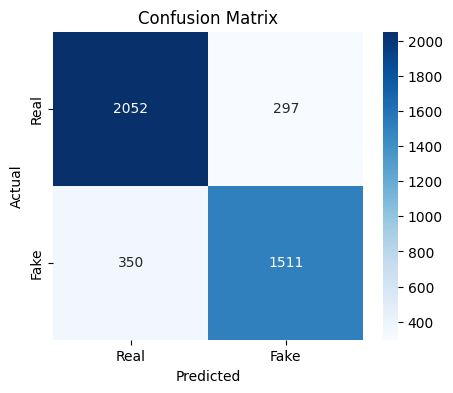

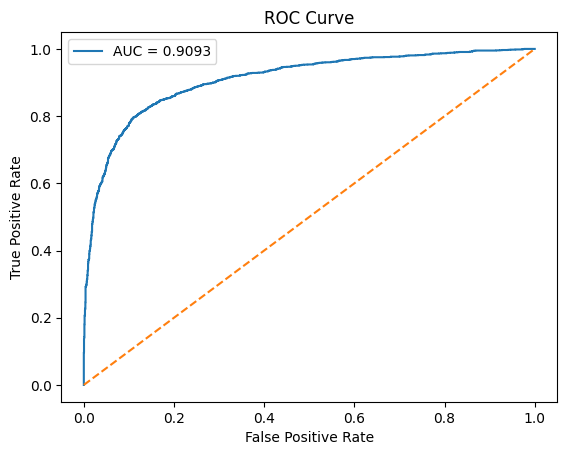

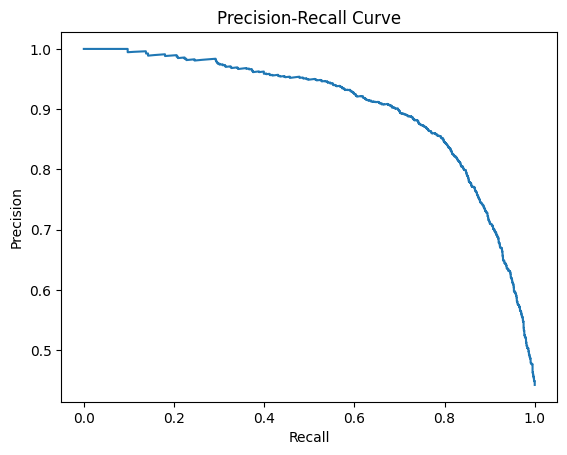


Final AUC: 0.9093442760578831


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)

# ==============================
# LOAD BEST MODEL
# ==============================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Final Evaluation"):
        pixel_values = batch["pixel_values"].to(DEVICE)
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        logits = model(pixel_values, input_ids, attention_mask)
        probs = F.softmax(logits, dim=1)[:, 1]

        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# ==============================
# DEFAULT 0.5 THRESHOLD METRICS
# ==============================
preds_default = (all_probs >= 0.5).astype(int)

print("\n===== DEFAULT 0.5 THRESHOLD =====")
print(classification_report(all_labels, preds_default, digits=4))

# ==============================
# THRESHOLD OPTIMIZATION
# ==============================
best_f1 = 0
best_thresh = 0.5

for t in np.arange(0.1, 0.9, 0.01):
    preds = (all_probs >= t).astype(int)
    f1 = f1_score(all_labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print("\nBest Threshold:", best_thresh)
print("Best F1:", best_f1)

preds_best = (all_probs >= best_thresh).astype(int)

print("\n===== BEST THRESHOLD REPORT =====")
print(classification_report(all_labels, preds_best, digits=4))

# ==============================
# CONFUSION MATRIX
# ==============================
cm = confusion_matrix(all_labels, preds_best)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ==============================
# ROC CURVE
# ==============================
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# ==============================
# PRECISION-RECALL CURVE
# ==============================
precision, recall, _ = precision_recall_curve(all_labels, all_probs)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

print("\nFinal AUC:", roc_auc)